In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import warnings
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")


In [2]:
# Load the dataset
amazon_book_df = pd.read_csv("Data/Amazon_Data/books_data.csv")
amazon_book_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [3]:
# Drop unimportant columns
amazon_book_df.drop(['image','previewLink','infoLink','ratingsCount','authors','publisher','publishedDate'], inplace=True, axis=1)
amazon_book_df.head()

,Title,description,categories
0,Its Only Art If Its Well Hung!,NaN,['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['Religion']
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Fiction']
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,NaN


In [4]:
amazon_book_df.shape

(212404, 3)

In [5]:
# Check for null/missing values
amazon_book_df.isna().sum()

Title              1
description    68442
categories     41199
dtype: int64

In [6]:
# Drop rows where the description is missing
amazon_book_df = amazon_book_df.dropna(subset=['description']).reset_index(drop = True)
amazon_book_df.isna().sum()

Title             0
description       0
categories     6074
dtype: int64

In [7]:
amazon_book_df.shape

(143962, 3)

In [8]:
len(amazon_book_df['categories'].unique())

5416

In [9]:
amazon_book_df['categories'].unique()

array(["['Biography & Autobiography']", "['Religion']", "['Fiction']",
       ..., "['Tarzan (Fictitious character)']", "['Outlaws']",
       "['Flame in the wind (Motion picture)']"], dtype=object)

In [10]:
# Drop categories as these are not correct
amazon_book_df.drop('categories', inplace=True, axis=1)
amazon_book_df.head()

,Title,description
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...
2,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...
3,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...
4,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...


In [11]:
# Function to clean the description
wn = nltk.WordNetLemmatizer()

def clean_description(desc):
    # Lowercase the review
    desc= desc.lower()
    
    # Remove URLs, links
    desc = re.sub(r"http\S+", "", desc)
    desc = re.sub(r"www.\S+", "", desc)
    desc = re.sub(r"\S+@\S+", "", desc)
    
    # Remove punctuations
    desc_punc = "".join(char for char in desc if char not in string.punctuation)
    
    # Remove stopwords
    stopword = nltk.corpus.stopwords.words('english')
    desc_stopwords = " ".join([word for word in re.split('\W+', desc_punc) if word not in stopword])
    
    # Lemmatization
    desc_cleaned = " ".join([wn.lemmatize(word,'n') for word in re.split('\W+', desc_stopwords)])

    return desc_cleaned

In [12]:
# Clean Description
amazon_book_df['clean_description'] = amazon_book_df['description'].apply(clean_description)
amazon_book_df.head()

,Title,description,clean_description
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,philip nel take fascinating look key aspect se...
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,resource includes twelve principle understandi...
2,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,julia thomas find life spinning control death ...
3,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,church christ biblical ecclesiology today resp...
4,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,story child 10 st hyacinth dominican planted f...


In [13]:
# Drop the old 'description' column
amazon_book_df.drop('description', inplace= True, axis=1)
amazon_book_df.head()

,Title,clean_description
0,Dr. Seuss: American Icon,philip nel take fascinating look key aspect se...
1,Wonderful Worship in Smaller Churches,resource includes twelve principle understandi...
2,Whispers of the Wicked Saints,julia thomas find life spinning control death ...
3,The Church of Christ: A Biblical Ecclesiology ...,church christ biblical ecclesiology today resp...
4,Saint Hyacinth of Poland,story child 10 st hyacinth dominican planted f...


In [14]:
# Using Count Vectorizer
cv = CountVectorizer(min_df = 100)
amazon_book = cv.fit_transform(amazon_book_df['clean_description']).todense()

In [15]:
amazon_book = np.asarray(amazon_book)

In [16]:
# Performing LDA
lda = LatentDirichletAllocation(n_components=10, random_state = 20)
amazon_book_genres = lda.fit_transform(amazon_book)

In [17]:
amazon_book_genres

array([[0.00192342, 0.11186926, 0.69841732, ..., 0.06139523, 0.00192348,
        0.00192347],
       [0.00555712, 0.00555767, 0.00555684, ..., 0.00555775, 0.00555739,
        0.15746982],
       [0.00116292, 0.10325086, 0.00116291, ..., 0.00116306, 0.00116296,
        0.0011629 ],
       ...,
       [0.00135161, 0.41215264, 0.00135173, ..., 0.00135154, 0.00135167,
        0.34941383],
       [0.00161314, 0.0522669 , 0.19263287, ..., 0.14037741, 0.05884173,
        0.00161315],
       [0.25097589, 0.13822533, 0.00175468, ..., 0.00175485, 0.00175479,
        0.00175457]])

In [18]:
amazon_book_genres.shape

(143962, 10)

In [19]:
# Perform KMeans Clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(amazon_book_genres)

KMeans(n_clusters=10)

In [20]:
# TSNE for visualizing the clusters
genres_tsne = TSNE(n_components=2, perplexity=5, random_state=0).fit_transform(amazon_book_genres)

<Axes: >

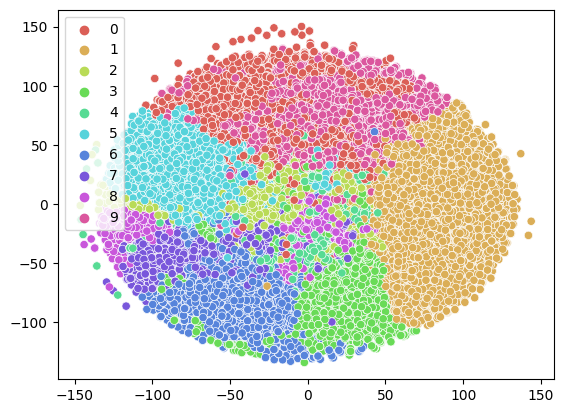

In [21]:
sns.scatterplot(x = genres_tsne[:,0], y = genres_tsne[:,1], hue = kmeans.labels_, palette = sns.hls_palette(10), legend = 'full')

In [22]:
# Dictionary that holds the indices of the values in each cluster
mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

dictlist = []
for key, value in mydict.items():
    temp = [key,value]
    dictlist.append(temp)

  0%|          | 0/10 [00:00<?, ?it/s]

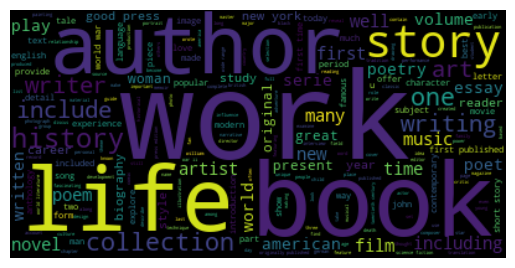

 10%|█         | 1/10 [00:03<00:32,  3.61s/it]

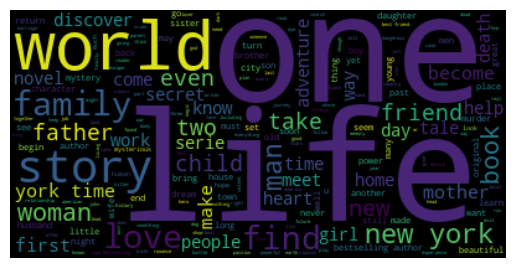

 20%|██        | 2/10 [00:11<00:48,  6.12s/it]

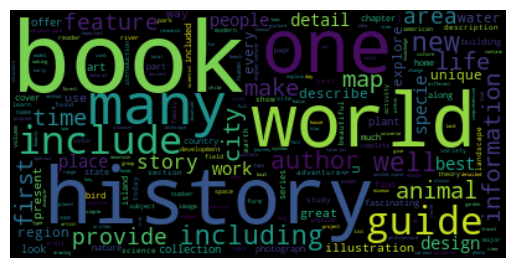

 30%|███       | 3/10 [00:13<00:30,  4.35s/it]

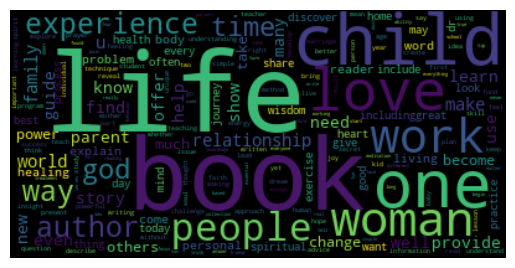

 40%|████      | 4/10 [00:17<00:24,  4.09s/it]

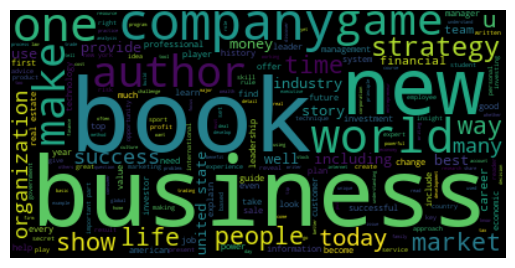

 50%|█████     | 5/10 [00:19<00:16,  3.33s/it]

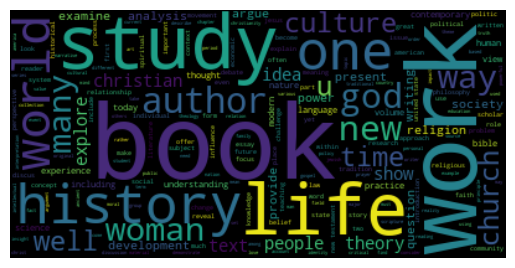

 60%|██████    | 6/10 [00:23<00:14,  3.75s/it]

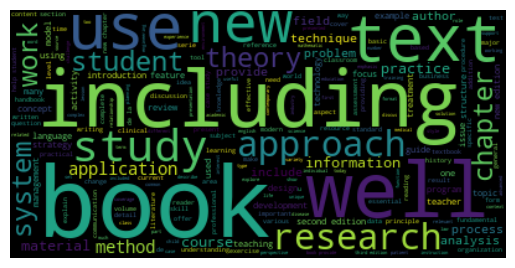

 70%|███████   | 7/10 [00:27<00:11,  3.78s/it]

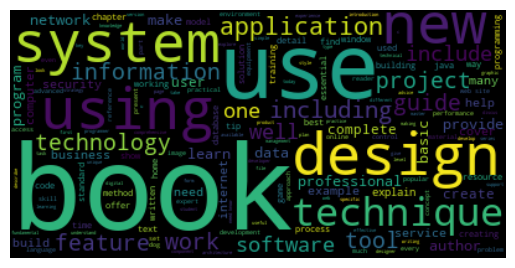

 80%|████████  | 8/10 [00:29<00:06,  3.18s/it]

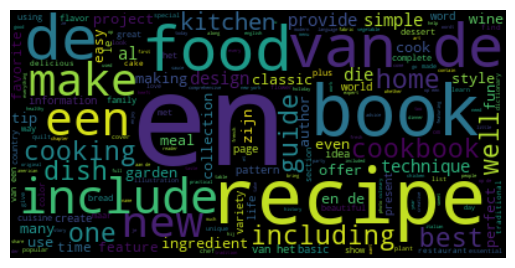

 90%|█████████ | 9/10 [00:31<00:02,  2.74s/it]

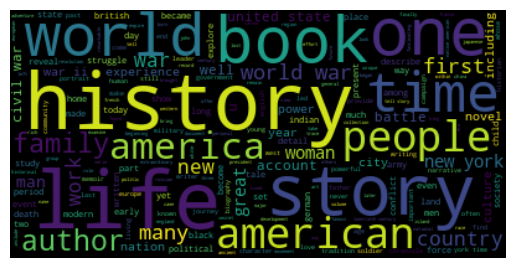

100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


In [23]:
# Generate word clouds for each cluster to get the topic of that cluster
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

for i in tqdm(range(10)):
    text = []
    for j in range(len(dictlist[i][1])):
        text.append(amazon_book_df['clean_description'].iloc[dictlist[i][1][j]])
    new_text = (" ").join(text)

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(new_text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Perform Content based filtering using the LDA topics as features of a book

In [24]:
amazon_book_df

,Title,clean_description
0,Dr. Seuss: American Icon,philip nel take fascinating look key aspect se...
1,Wonderful Worship in Smaller Churches,resource includes twelve principle understandi...
2,Whispers of the Wicked Saints,julia thomas find life spinning control death ...
3,The Church of Christ: A Biblical Ecclesiology ...,church christ biblical ecclesiology today resp...
4,Saint Hyacinth of Poland,story child 10 st hyacinth dominican planted f...
...,...,...
143957,The Orphan Of Ellis Island (Time Travel Advent...,school trip elli island dominick avaro tenyear...
143958,Red Boots for Christmas,everyone village friedensdorf happily preparin...
143959,Mamaw,give mamaw useful beautiful thoughtful gift sh...
143960,The Autograph Man,alexli tandem sell autograph business hunt nam...


In [25]:
#Create Data Frame of book topics and its title and summary 

cols = ["topic_"+str(i+1) for i in range(10)]
amazon_book_genres_df = pd.DataFrame(amazon_book_genres)
amazon_book_genres_df.columns = cols
amazon_book_genres_df
amazon_book_genres_df = pd.concat([amazon_book_df, amazon_book_genres_df], axis=1)
amazon_book_genres_df

,Title,clean_description,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,Dr. Seuss: American Icon,philip nel take fascinating look key aspect se...,0.001923,0.111869,0.698417,0.116777,0.001924,0.001923,0.001924,0.061395,0.001923,0.001923
1,Wonderful Worship in Smaller Churches,resource includes twelve principle understandi...,0.005557,0.005558,0.005557,0.440740,0.005557,0.362889,0.005557,0.005558,0.005557,0.157470
2,Whispers of the Wicked Saints,julia thomas find life spinning control death ...,0.001163,0.103251,0.001163,0.070494,0.818115,0.001163,0.001163,0.001163,0.001163,0.001163
3,The Church of Christ: A Biblical Ecclesiology ...,church christ biblical ecclesiology today resp...,0.002440,0.002439,0.002439,0.921051,0.002439,0.059435,0.002439,0.002439,0.002439,0.002439
4,Saint Hyacinth of Poland,story child 10 st hyacinth dominican planted f...,0.002778,0.199587,0.002779,0.002779,0.002779,0.002778,0.778184,0.002779,0.002778,0.002779
...,...,...,...,...,...,...,...,...,...,...,...,...
143957,The Orphan Of Ellis Island (Time Travel Advent...,school trip elli island dominick avaro tenyear...,0.006250,0.006252,0.006251,0.006250,0.818133,0.006251,0.131858,0.006251,0.006253,0.006252
143958,Red Boots for Christmas,everyone village friedensdorf happily preparin...,0.006251,0.006252,0.006253,0.006252,0.771794,0.006251,0.006251,0.006253,0.006251,0.178191
143959,Mamaw,give mamaw useful beautiful thoughtful gift sh...,0.001352,0.412153,0.001352,0.001352,0.228972,0.001352,0.001352,0.001352,0.001352,0.349414
143960,The Autograph Man,alexli tandem sell autograph business hunt nam...,0.001613,0.052267,0.192633,0.077781,0.471647,0.001613,0.001613,0.140377,0.058842,0.001613


In [26]:
amazon_book_genres_df = amazon_book_genres_df.rename(columns={"Title": "Book-Title"})
amazon_book_genres_df

,Book-Title,clean_description,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,Dr. Seuss: American Icon,philip nel take fascinating look key aspect se...,0.001923,0.111869,0.698417,0.116777,0.001924,0.001923,0.001924,0.061395,0.001923,0.001923
1,Wonderful Worship in Smaller Churches,resource includes twelve principle understandi...,0.005557,0.005558,0.005557,0.440740,0.005557,0.362889,0.005557,0.005558,0.005557,0.157470
2,Whispers of the Wicked Saints,julia thomas find life spinning control death ...,0.001163,0.103251,0.001163,0.070494,0.818115,0.001163,0.001163,0.001163,0.001163,0.001163
3,The Church of Christ: A Biblical Ecclesiology ...,church christ biblical ecclesiology today resp...,0.002440,0.002439,0.002439,0.921051,0.002439,0.059435,0.002439,0.002439,0.002439,0.002439
4,Saint Hyacinth of Poland,story child 10 st hyacinth dominican planted f...,0.002778,0.199587,0.002779,0.002779,0.002779,0.002778,0.778184,0.002779,0.002778,0.002779
...,...,...,...,...,...,...,...,...,...,...,...,...
143957,The Orphan Of Ellis Island (Time Travel Advent...,school trip elli island dominick avaro tenyear...,0.006250,0.006252,0.006251,0.006250,0.818133,0.006251,0.131858,0.006251,0.006253,0.006252
143958,Red Boots for Christmas,everyone village friedensdorf happily preparin...,0.006251,0.006252,0.006253,0.006252,0.771794,0.006251,0.006251,0.006253,0.006251,0.178191
143959,Mamaw,give mamaw useful beautiful thoughtful gift sh...,0.001352,0.412153,0.001352,0.001352,0.228972,0.001352,0.001352,0.001352,0.001352,0.349414
143960,The Autograph Man,alexli tandem sell autograph business hunt nam...,0.001613,0.052267,0.192633,0.077781,0.471647,0.001613,0.001613,0.140377,0.058842,0.001613


In [27]:
def content_based(bookTitle, df):
    bookTitle=str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        common_books = df.copy()
        
        # remove duplicates

        common_books=common_books.drop_duplicates(subset=["Book-Title"])
        common_books.reset_index(inplace=True)
        
        # add indexes to the book
        common_books["index"]=[i for i in range(common_books.shape[0])]
        
        # select targets for creating features
        targets=cols

        # get index for our given book title
        index=common_books[common_books["Book-Title"].str.lower()==bookTitle.lower()]["index"].values[0]

        # find similarity basefd on the vectors
        similarity=cosine_similarity(common_books.loc[index, targets].values.reshape(1,-1), common_books[targets].values)
        
        #sort the simlar books from similarity matrix and select first 5 books
        similar_books=list(enumerate(similarity[0]))
        similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
        
        books=[]
        similarity_scores=[]
        for i in range(len(similar_booksSorted)):
            books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())
            similarity_scores.append(similar_booksSorted[i][1])
            
        # print the recommended books
        print('You May Like These Books')
        print('***********************')
        for i in range(len(books)):
            
            book_name=common_books.loc[common_books["Book-Title"]==books[i],"Book-Title"][:1].values[0]
            score = similarity_scores[i]
            print(str(i+1)+". "+book_name+' | Similarity Score: ' + str(score))
    else:
        print("COULD NOT FIND ") 

In [33]:
amazon_book_genres_df

,Book-Title,clean_description,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,Dr. Seuss: American Icon,philip nel take fascinating look key aspect se...,0.001923,0.111869,0.698417,0.116777,0.001924,0.001923,0.001924,0.061395,0.001923,0.001923
1,Wonderful Worship in Smaller Churches,resource includes twelve principle understandi...,0.005557,0.005558,0.005557,0.440740,0.005557,0.362889,0.005557,0.005558,0.005557,0.157470
2,Whispers of the Wicked Saints,julia thomas find life spinning control death ...,0.001163,0.103251,0.001163,0.070494,0.818115,0.001163,0.001163,0.001163,0.001163,0.001163
3,The Church of Christ: A Biblical Ecclesiology ...,church christ biblical ecclesiology today resp...,0.002440,0.002439,0.002439,0.921051,0.002439,0.059435,0.002439,0.002439,0.002439,0.002439
4,Saint Hyacinth of Poland,story child 10 st hyacinth dominican planted f...,0.002778,0.199587,0.002779,0.002779,0.002779,0.002778,0.778184,0.002779,0.002778,0.002779
...,...,...,...,...,...,...,...,...,...,...,...,...
143957,The Orphan Of Ellis Island (Time Travel Advent...,school trip elli island dominick avaro tenyear...,0.006250,0.006252,0.006251,0.006250,0.818133,0.006251,0.131858,0.006251,0.006253,0.006252
143958,Red Boots for Christmas,everyone village friedensdorf happily preparin...,0.006251,0.006252,0.006253,0.006252,0.771794,0.006251,0.006251,0.006253,0.006251,0.178191
143959,Mamaw,give mamaw useful beautiful thoughtful gift sh...,0.001352,0.412153,0.001352,0.001352,0.228972,0.001352,0.001352,0.001352,0.001352,0.349414
143960,The Autograph Man,alexli tandem sell autograph business hunt nam...,0.001613,0.052267,0.192633,0.077781,0.471647,0.001613,0.001613,0.140377,0.058842,0.001613


In [34]:
amazon_book_genres_df = amazon_book_genres_df[amazon_book_genres_df['Book-Title'] != "To kill a mockingbird"]

In [35]:
content_based("To Kill A Mockingbird", amazon_book_genres_df)

You May Like These Books
***********************
1. Land of Eight Million Dreams: Year of the Lotus (Changeling: The Dreaming) | Similarity Score: 0.9998877528445828
2. Mastro-don Gesualdo | Similarity Score: 0.999613779983612
3. The Heart of a Chief | Similarity Score: 0.9993474735690379
4. Berlin: A Novel | Similarity Score: 0.9992548139157348
5. The Mysterious Mr. I | Similarity Score: 0.9991429424211944


In [36]:
content_based(".NET Multithreading", amazon_book_genres_df)

You May Like These Books
***********************
1. Flash MX Learning Studio | Similarity Score: 0.9999997180666773
2. Learning Cocoa with Objective-C, 2nd Edition | Similarity Score: 0.9999997127918477
3. Microsoft Exchange Server 2003 Deployment and Migration (HP Technologies) | Similarity Score: 0.999999648448785
4. C Algorithms for Real-Time DSP | Similarity Score: 0.9999910488427768
5. Instant CORBA | Similarity Score: 0.9999895721726314


In [37]:
content_based("1984", amazon_book_genres_df)

You May Like These Books
***********************
1. Los Nombres ms Bellos y Originales para tu Nia (Spanish Edition) | Similarity Score: 1.0
2. You Can Write a Novel | Similarity Score: 1.0
3. Shappy! Poet/Comedian/A**hole | Similarity Score: 1.0
4. Barbie & the Scavenger Hunt (Little Golden Book) | Similarity Score: 0.9999919124390779
5. The Retreat | Similarity Score: 0.9999857489962933


In [38]:
content_based("Wizard of Oz", amazon_book_genres_df)

You May Like These Books
***********************
1. The Wonderful Wizard of Oz | Similarity Score: 0.9999999999999999
2. The Wonderful Wizard Of Oz | Similarity Score: 0.9999999999999999
3. The Wonderful Wizard of Oz (Troll Illustrated Classics) | Similarity Score: 0.9999999999999999
4. There Are 508 Stars In The Sky | Similarity Score: 0.9999999999985851
5. One Quest, Hold the Dragons (Cups and Sorcery) | Similarity Score: 0.9999999999985851
